In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time

%matplotlib inline

In [160]:
def dft_matrix(N):
    i, j = np.meshgrid(np.arange(N), np.arange(N))
    omega = np.exp( - 2 * np.pi * 1j / N )
    W = np.power( omega, i * j )
    return W

def idft_matrix(N):
    i, j = np.meshgrid(np.arange(N), np.arange(N))
    omega = np.exp(2 * np.pi * 1j / N )
    W = np.power( omega, i * j ) / N
    return W

def dft(I):
    (M, N) = I.shape
    
    W_N = dft_matrix(N)
    W_M = dft_matrix(M)
    
    It = np.zeros((M, N), dtype=np.complex)
    It = W_M@I@W_N
    return It

def idft(It):
    (M, N) = It.shape
    W_N = idft_matrix(N)
    W_M = idft_matrix(M)
    
    I = np.zeros((M, N), dtype=int)
    I = np.clip(np.real(W_M@It@W_N), 0, 255)
    return I

def CONVOLVE(f, h):
    (M, N, C) = f.shape
    (m, n, c) = h.shape
    mid_m = (m-1)//2
    mid_n = (n-1)//2
    if C != c:
        print("Channel diemensions are mismatching f:{} and h:{}".format(C, c))
        return None
    y = np.zeros((M, N, C), dtype=int)
    for i in range(C):
        h_padded = np.vstack((np.hstack((h[:, :, i], np.zeros((m, 2*N - n)))), np.zeros((2*M-m, 2*N))))
        f_padded = np.vstack((np.hstack((f[:, :, i], np.zeros((M, N)))), np.zeros((M, 2*N))))
        y[:, :, i] = idft(dft(h_padded) * dft(f_padded))[mid_m:(M+mid_m), mid_n:(N+mid_m)]
    return y

def gaussian_filter(sigma, N, C):
    H = np.zeros((N, N, C))
    for k in range(C):
        mid = N//2
        for i in range(N):
            for j in range(N):
                H[i, j, k] = np.exp(-2*np.power(np.pi*sigma, 2)*((mid-i)**2 + (mid-j)**2)/(N**2))
        H[:, :, k] = H[:, :, k]/np.sum(H[:, :, k])
    return H

In [144]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [13]:
images = unpickle("./cifar-10-python/cifar-10-batches-py/data_batch_1")
print(images.keys())
print(images[b'data'].shape)

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
(10000, 3072)


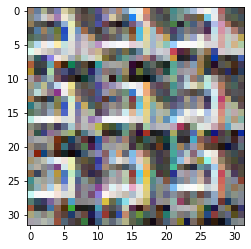

In [17]:
r = images[b'data'][1,:].reshape(32, 32, 3)
plt.imshow(r)

In [29]:
def extract_data(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    data = dict[b'data']
    labels = dict[b'labels']
    images = []
    for i in range(data.shape[0]):
        img = np.zeros((32, 32, 3), dtype=int)
        for j in range(data.shape[1]):
            x = j//1024
            img[(j - 1024*x)//32, (j - 1024*x)%32, x] = data[i, j]
        images.append(img)
    dct = {'X':np.array(images), 'Y':labels}
    return dct

In [41]:
%%time
data = extract_data("./cifar-10-python/cifar-10-batches-py/data_batch_1")

CPU times: user 11.8 s, sys: 24.4 ms, total: 11.8 s
Wall time: 11.6 s


[[[5.17000575e-06 5.17000575e-06 5.17000575e-06]
  [1.61732949e-05 1.61732949e-05 1.61732949e-05]
  [4.24526529e-05 4.24526529e-05 4.24526529e-05]
  [9.34996561e-05 9.34996561e-05 9.34996561e-05]
  [1.72788184e-04 1.72788184e-04 1.72788184e-04]
  [2.67927269e-04 2.67927269e-04 2.67927269e-04]
  [3.48592986e-04 3.48592986e-04 3.48592986e-04]
  [3.80556566e-04 3.80556566e-04 3.80556566e-04]
  [3.48592986e-04 3.48592986e-04 3.48592986e-04]
  [2.67927269e-04 2.67927269e-04 2.67927269e-04]
  [1.72788184e-04 1.72788184e-04 1.72788184e-04]
  [9.34996561e-05 9.34996561e-05 9.34996561e-05]
  [4.24526529e-05 4.24526529e-05 4.24526529e-05]
  [1.61732949e-05 1.61732949e-05 1.61732949e-05]
  [5.17000575e-06 5.17000575e-06 5.17000575e-06]]

 [[1.61732949e-05 1.61732949e-05 1.61732949e-05]
  [5.05948119e-05 5.05948119e-05 5.05948119e-05]
  [1.32804354e-04 1.32804354e-04 1.32804354e-04]
  [2.92494358e-04 2.92494358e-04 2.92494358e-04]
  [5.40532139e-04 5.40532139e-04 5.40532139e-04]
  [8.38155111e-04 

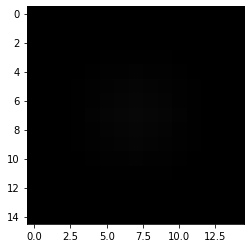

In [176]:
h = gaussian_filter(sigma=1, N=15, C=3)
print((h))
plt.imshow(h)

In [177]:
image = data['X'][0, :]
h_image = CONVOLVE(image, h)

<ipython-input-160-1c0df6746a4b>:19: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  It = np.zeros((M, N), dtype=np.complex)


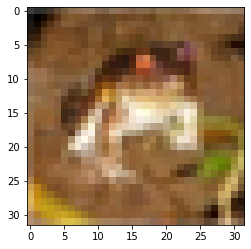

In [178]:
plt.imshow(image)

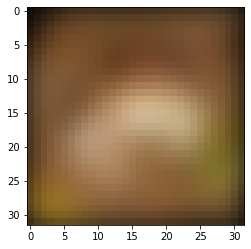

In [179]:
plt.imshow(h_image)

In [158]:
print(h_image.shape)

(32, 32, 3)


In [190]:
def max_pool(image):
    (M, N, C) = image.shape
    if M!=N:
        print("Not implemented!")
        return None
    m = M//2
    y = np.zeros((m, m, C), dtype=int)
    for k in range(C):
        for i in range(m):
            for j in range(m):
                y[i, j, k] = np.max(image[(2*i):(2*i+2), (2*j):(2*j+2), k])
    return y

def ReLU(x):
    return np.max(0, x)

In [ ]:
def weight_init():
    
def feed_forward(image):
    # Weights and bias initialisation
    
    # CONV layer with 4 kernels of size 3x3, ReLU
    x1 = CONVOLVE(image, kernel_1)
    x2 = ReLU(x1)
    # Max pooling of size 2x2 with a stride of 2
    x3 = max_pool(x2)
    # CONV layer with 8 kernels of size 3x3, ReLU
    x4 = CONVOLVE(x3, kernel_2)
    x5 = ReLU(x4)
    # Max pooling of size 2x2 with a stride of 2
    x6 = max_pool(x5)
    # Flattening layer
    x7 = x6.reshape(-1, 1)
    # MLP hidden layer
    x8 = W1@x7 + b1
    x9 = ReLU(x8)
    # MLP output layer
    x10 = W2@x9 + b2
    y = ReLU(x10) 
    